# Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch, torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from sklearn.preprocessing import MinMaxScaler
import time
import seaborn as sns

gpu = torch.device('cuda:0')
cpu = torch.device('cpu')

def RMSE(errs):
    return np.sqrt(np.mean(errs**2))

# Explore Temperature Data

In [2]:
os.chdir('Q:\\Capstone Data\\Exercises')
temp = pd.read_csv('temp.csv')

In [3]:
temp.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
temp.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


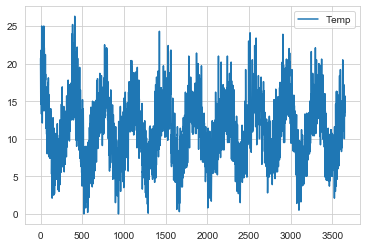

In [5]:
sns.set_style('whitegrid')
temp.plot();

In [6]:
temp['Date'] = pd.to_datetime(temp.Date)
temp.set_index('Date', inplace=True)
temp.index.name=None
temp.head()

,Temp
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


**Confirm all observations are of type float**

In [7]:
temp.Temp.apply(lambda x: type(x)).unique()

array([<class 'float'>], dtype=object)

**80/20 train/test split (8 years train/2 years test)**

In [8]:
train = temp[:-730].copy()
test = temp[-730:].copy()

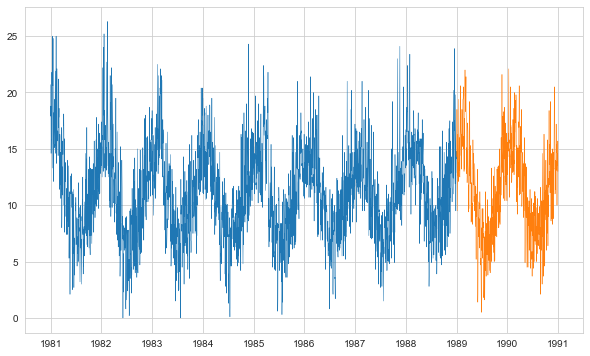

In [9]:
plt.figure(figsize=(10,6))
plt.plot(train, linewidth=.5); plt.plot(test, linewidth=.5);

**Normalize data (min-max)**

In [10]:
scaler = MinMaxScaler()
scaler.fit(train)

train_scaled = train.copy()
train_scaled['Temp'] = scaler.transform(train)

test_scaled = test.copy()
test_scaled['Temp'] = scaler.transform(test)

In [11]:
# Verify train tail and test head of scaled data

pd.concat([train_scaled.tail(3), test_scaled.head(3)], axis=1)

,Temp,Temp
1988-12-28,0.490494,NaN
1988-12-29,0.562738,NaN
1988-12-30,0.536122,NaN
1989-01-01,NaN,0.543726
1989-01-02,NaN,0.661597
1989-01-03,NaN,0.703422


In [12]:
train_array = train_scaled.Temp.values
test_array = test_scaled.Temp.values

***

# Build LSTM

## <span style="color:blue">Implementation A</span>

**Create train/test sets for 1-day forecasts learned from 365-day sequences**

In [13]:
num_preds = 1
window = 365

### Train ###
X_train = []
y_train = []
for i in range(len(train_array)-window):
    X_train.append(train_array[i:(i+window)])
    y_train.append(train_array[(i+window):(i+window+num_preds)])

X_train = np.array(X_train)
y_train = np.array(y_train)
print(y_train.shape)


### Test ###
X_test = []
y_test = []
for i in range(len(test_array)-window):
    X_test.append(test_array[i:(i+window)])
    y_test.append(test_array[(i+window):(i+window+num_preds)])

X_test = np.array(X_test)
y_test = np.array(y_test)
print(y_test.shape)

(2555, 1)
(365, 1)


In [15]:
X_train_tensor = torch.tensor(X_train).float().to(gpu)
y_train_tensor = torch.tensor(y_train).float().to(gpu)
X_test_tensor = torch.tensor(X_test).float().to(gpu)
y_test_tensor = torch.tensor(y_test).float().to(gpu)

**Design LSTM**

In [16]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm = nn.LSTM(1, 100)
        self.hidden_cell = (torch.zeros(1, 1, 100))
        self.dense1 = nn.Linear(100, 1)
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.dense1(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [17]:
model = LSTM()

**Create Dataloader object**

In [18]:
# dataloader
class torchData(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y), 'X, y have different lengths'
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
dataset = torchData(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)

**Define loss function and optimizer**

In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [20]:
model.parameters

<bound method Module.parameters of LSTM(
  (lstm): LSTM(1, 100)
  (dense1): Linear(in_features=100, out_features=1, bias=True)
)>

**Train model**

In [20]:
model.to(gpu)

epoch_losses = []
epochs=100
start_time = time.time()

for e in range(epochs):
    epoch_loss = 0
    for i, data in enumerate(dataloader):
        seq, labels = torch.flatten(data[0]), torch.flatten(data[1])
        
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, 100).to(gpu), 
                            torch.zeros(1, 1, 100).to(gpu))
        pred = model(seq)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    print('Epoch: ', e+1)
    print('Elapsed time: ', time.time()-start_time)
    print('Epoch loss: ', epoch_loss)
    epoch_losses.append(epoch_loss)

Epoch:  1
Elapsed time:  33.06073808670044
Epoch loss:  66.46749769075268
Epoch:  2
Elapsed time:  66.05525302886963
Epoch loss:  30.854593127510977
Epoch:  3
Elapsed time:  99.44607329368591
Epoch loss:  29.851757326772375
Epoch:  4
Elapsed time:  132.96739649772644
Epoch loss:  28.576973288586803
Epoch:  5
Elapsed time:  166.04803204536438
Epoch loss:  27.35739774473779
Epoch:  6
Elapsed time:  199.06839060783386
Epoch loss:  26.10882859340878
Epoch:  7
Elapsed time:  232.01317167282104
Epoch loss:  24.94621397441928
Epoch:  8
Elapsed time:  265.36785650253296
Epoch loss:  24.09044888617602
Epoch:  9
Elapsed time:  298.3565104007721
Epoch loss:  23.61393106676969
Epoch:  10
Elapsed time:  331.5242762565613
Epoch loss:  23.382431553825562
Epoch:  11
Elapsed time:  365.30613946914673
Epoch loss:  23.24768365263797
Epoch:  12
Elapsed time:  398.661780834198
Epoch loss:  23.15067780749577
Epoch:  13
Elapsed time:  431.7128219604492
Epoch loss:  23.112592593928397
Epoch:  14
Elapsed time:

In [21]:
# torch.save(model, 'LSTM_A.pkl')

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:401: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [22]:
model = torch.load('LSTM_A.pkl')

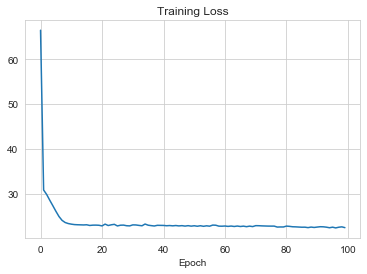

In [22]:
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.plot(epoch_losses);

**Generate train predictions**

In [23]:
dataset = torchData(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)

model.to(gpu)
model.eval()
train_preds = torch.tensor([], dtype=torch.float).to(gpu)
for i, data in enumerate(dataloader):
    inputs, target = data
    inputs = inputs[0].to(gpu)
    with torch.no_grad(): preds = model(inputs)
    train_preds = torch.cat((train_preds, preds))

train_preds = train_preds.to(cpu).numpy().reshape((len(train_preds), 1))
train_preds = scaler.inverse_transform(train_preds)
train_targets = scaler.inverse_transform(y_train)

**RMSE**

In [24]:
train_error = train_preds.reshape(len(train_preds), 1)-train_targets
print('RMSE: ', np.sqrt((train_error**2).sum()/len(train_error)))

RMSE:  2.58846504287921


count    2555.000000
mean        0.629104
std         2.511344
min        -9.667341
25%        -0.956140
50%         0.635972
75%         2.260438
max         8.392957
dtype: float64

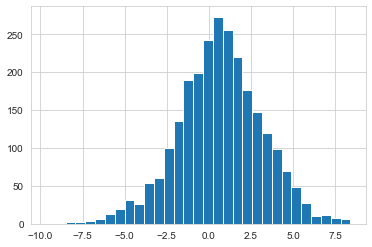

In [25]:
plt.hist(train_error, bins=31);
pd.Series(train_error.flatten()).describe()

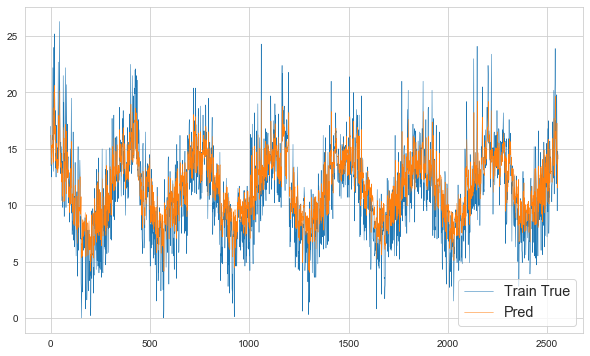

In [26]:
plt.figure(figsize = (10,6))
plt.plot(train_targets, linewidth=.5)
plt.plot(train_preds, linewidth=.5)
plt.legend(('Train True', 'Pred'), fontsize='x-large');

**Generate test predictions**

In [28]:
dataset = torchData(torch.tensor(np.array(X_test)).float(), torch.tensor(np.array(y_test)).float())
dataloader = DataLoader(dataset=dataset, batch_size=1)

model.to(gpu)
model.eval()
test_preds = torch.tensor([], dtype=torch.float).to(gpu)
for i, data in enumerate(dataloader):
    inputs, target = data
    inputs = inputs[0].to(gpu)
    with torch.no_grad(): preds = model(inputs)
    test_preds = torch.cat((test_preds, preds))

test_preds = test_preds.to(cpu).numpy().reshape((len(test_preds), 1))
test_preds = scaler.inverse_transform(test_preds)
test_targets = scaler.inverse_transform(np.array(y_test))

**RMSE**

In [29]:
test_error = test_preds.reshape(len(test_preds),1) - test_targets
print('RMSE: ', np.sqrt(np.mean(test_error**2)))

RMSE:  2.357141678584676


count    365.000000
mean       0.439564
std        2.318973
min       -6.412296
25%       -0.993050
50%        0.353341
75%        1.841576
max        7.219197
dtype: float64

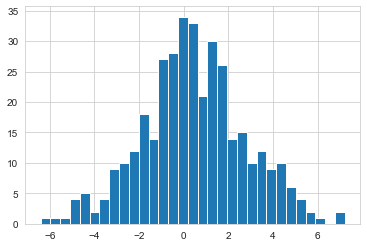

In [30]:
plt.hist(test_error, bins=31);
pd.Series(test_error.flatten()).describe()

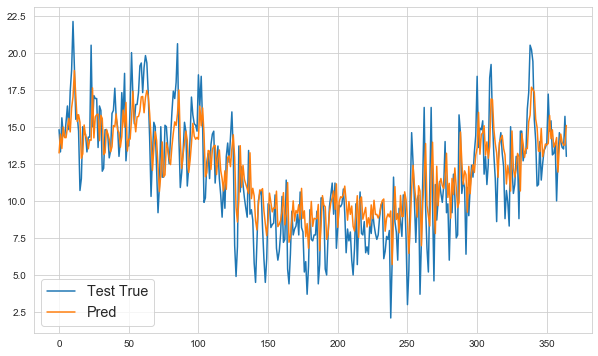

In [31]:
plt.figure(figsize=(10,6))
plt.plot(test_targets)
plt.plot(test_preds)
plt.legend(('Test True', 'Pred'), fontsize='x-large');

### Compare 1-day forecast against Random Walk

Mean: -0.0022610483042137647
Std Dev: 2.7902859118828296


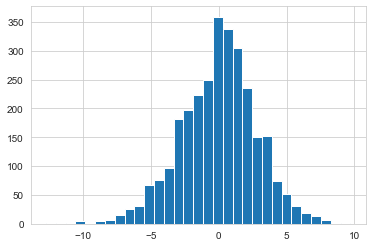

In [32]:
# Calculate the 1 day temperature changes of the train set
train_diffs = np.diff(train.Temp)

mu = np.mean(train_diffs)
sd = np.std(train_diffs)

print('Mean: ', mu,'\n', 'Std Dev: ', sd, sep='')
plt.hist(train_diffs, bins=31);

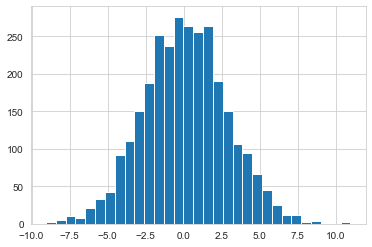

In [33]:
# Sample random changes from normal distribution with mean mu and standard deviation sd as defined above.
# Sampling from a non-normal distribution generated using all 4 moments would be preferable 
# but not necessary for this purpose

np.random.seed(42)
random_train_changes = np.random.normal(mu, sd, len(train_diffs))
plt.hist(random_train_changes, bins=31);

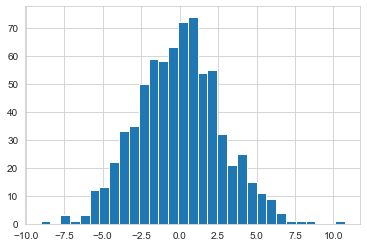

In [34]:
test_diffs = np.diff(test.Temp)
np.random.seed(42)
random_test_changes = np.random.normal(mu, sd, len(test_diffs))
plt.hist(random_test_changes, bins=31);

In [35]:
y_test_diffs = scaler.inverse_transform(np.diff(y_test, axis=0))
test_pred_diffs = np.diff(test_preds, axis=0)

**RMSE of y_test temperature delta vs. random value temperature delta**

In [36]:
test_random_errors = (y_test_diffs-random_test_changes)
RMSE(test_random_errors)

3.769427739429613

**RMSE of y_test temperature delta vs. predicted temperature delta**

In [37]:
test_pred_errors = (y_test_diffs - test_pred_diffs)
RMSE(test_pred_errors)

3.145474238367453

## Conclusion

This was a very rudimentary implementation with the sole purpose of demonstrating a proof of concept.  Without performing a KPSS test, the temperature dataset appeared stationary in terms of both mean and variance and therefore was a good candidate for a beginner-level univariate exercise.  Although I did not perform a statistical test, the results did not appear to be materially different from a random walk. For 1-day forecasts, it would probably make sense to reduce the training window from 365 days to ~30 days, possibly less.  Next, I will attempt to design a more complex network which predicts multiple periods into the future.

***

## <span style="color:blue">Implementation B</span>

**Create datasets for 10-day forecasts learned from 30-day sequences**

In [38]:
num_preds = 10
window = 30

X_train = []
y_train = []
for i in range(len(train_array)-window-num_preds):
    X_train.append(train_array[i:(i+window)])
    y_train.append(train_array[(i+window):(i+window+num_preds)])
    
X_test = []
y_test = []
for i in range(len(test_array)-window-num_preds):
    X_test.append(test_array[i:(i+window)])
    y_test.append(test_array[(i+window):(i+window+num_preds)])

In [40]:
print('X_train length: ', len(X_train))
print('y_train length: ', len(y_train))
print('X_train sample length: ', len(X_train[0]))
print('y_train sample length: ', len(y_train[0]))
print('X_test length: ', len(X_test))
print('y_test length: ', len(y_test))
print('X_test sample length: ', len(X_test[0]))
print('y_test sample length: ', len(y_test[0]))

X_train length:  2880
y_train length:  2880
X_train sample length:  30
y_train sample length:  10
X_test length:  690
y_test length:  690
X_test sample length:  30
y_test sample length:  10


**Confirm corresponding data in X and y sets align**

In [41]:
print('Train: ',np.all(X_train[num_preds][-num_preds:]==y_train[0]),'\n'
      'Test:  ',np.all(X_test[num_preds][-num_preds:]==y_test[0]))

Train:  True 
Test:   True


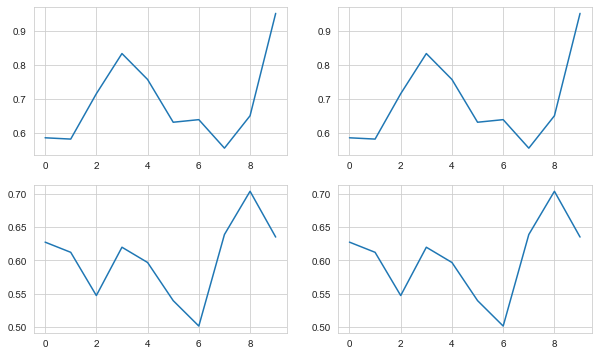

In [42]:
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(221); ax1.plot(X_train[num_preds][-num_preds:])
ax2 = f.add_subplot(222); ax2.plot(y_train[0])
ax3 = f.add_subplot(223); ax3.plot(X_test[num_preds][-num_preds:])
ax4 = f.add_subplot(224); ax4.plot(y_test[0]);

**Create tensors**

In [43]:
X_train_tensor = torch.tensor(np.array(X_train)).float().to(gpu)
y_train_tensor = torch.tensor(np.array(y_train)).float().to(gpu)

X_test_tensor = torch.tensor(np.array(X_test)).float().to(gpu)
y_test_tensor = torch.tensor(np.array(y_test)).float().to(gpu)

**Define network**

In [47]:
input_size = 1 
seq_length = window #(30)
num_layers = 4
hidden_nodes = 256
num_preds = num_preds #(10)
lr = 1e-4
drop_prob = .3

class LSTM(nn.Module):
    def __init__(self, input_size, seq_length, hidden_nodes, num_layers, num_preds):
        super().__init__()
        self.input_size = input_size
        self.hidden_nodes = hidden_nodes
        self.seq_length = seq_length
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, self.hidden_nodes, self.num_layers, dropout = drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.dense1 = nn.Linear(self.hidden_nodes*self.seq_length, num_preds)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_nodes).to(gpu)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_nodes).to(gpu)
        
        output, _ = self.lstm(x, (h0, c0))
        output = output.reshape(output.shape[0], -1)
        output = self.dense1(output)
        return output

model = LSTM(input_size, seq_length, hidden_nodes, num_layers, num_preds)

model.to(gpu)

LSTM(
  (lstm): LSTM(1, 256, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (dense1): Linear(in_features=7680, out_features=10, bias=True)
)

**Create Dataloader object**

In [48]:
class torchData(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y), 'X, y have different lengths'
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
dataset = torchData(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset=dataset, batch_size=5, shuffle=False)

**Define loss function and optimizer**

In [49]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.parameters

<bound method Module.parameters of LSTM(
  (lstm): LSTM(1, 256, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (dense1): Linear(in_features=7680, out_features=10, bias=True)
)>

**Train model**

In [50]:
epoch_losses = []
epochs=200
start_time = time.time()
for e in range(epochs):
    epoch_loss = 0
    for i, (seq, targets) in enumerate(dataloader):
        seq = seq.view(seq.shape[0], seq.shape[1], 1)
        seq = seq.to(gpu)
        targets = targets.to(gpu)
        optimizer.zero_grad()

        pred = model(seq)
        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print('Epoch: ', e+1)
    print('Elapsed time: ', time.time() - start_time)
    print('Epoch loss: ', epoch_loss)
    epoch_losses.append(epoch_loss)

Epoch:  1
Elapsed time:  10.423336029052734
Epoch loss:  15.780289482092485
Epoch:  2
Elapsed time:  20.912063360214233
Epoch loss:  16.382927800063044
Epoch:  3
Elapsed time:  31.301323413848877
Epoch loss:  17.105778811033815
Epoch:  4
Elapsed time:  41.80480360984802
Epoch loss:  16.99550558347255
Epoch:  5
Elapsed time:  52.262996435165405
Epoch loss:  16.580780375981703
Epoch:  6
Elapsed time:  62.68315243721008
Epoch loss:  16.492095143301412
Epoch:  7
Elapsed time:  73.18983268737793
Epoch loss:  16.19235362461768
Epoch:  8
Elapsed time:  83.65612053871155
Epoch loss:  15.72735457494855
Epoch:  9
Elapsed time:  94.17998814582825
Epoch loss:  14.308600707212463
Epoch:  10
Elapsed time:  104.80457067489624
Epoch loss:  12.174253119388595
Epoch:  11
Elapsed time:  115.34882855415344
Epoch loss:  10.417141657555476
Epoch:  12
Elapsed time:  126.10605382919312
Epoch loss:  9.644209913094528
Epoch:  13
Elapsed time:  136.51324129104614
Epoch loss:  9.40180969145149
Epoch:  14
Elapsed 

Epoch:  110
Elapsed time:  1180.474843263626
Epoch loss:  5.289772226475179
Epoch:  111
Elapsed time:  1191.2843751907349
Epoch loss:  5.110713934060186
Epoch:  112
Elapsed time:  1202.382473707199
Epoch loss:  5.084910333855078
Epoch:  113
Elapsed time:  1213.2230813503265
Epoch loss:  4.937586218584329
Epoch:  114
Elapsed time:  1224.0051703453064
Epoch loss:  4.799386572558433
Epoch:  115
Elapsed time:  1234.902021408081
Epoch loss:  4.709639116190374
Epoch:  116
Elapsed time:  1245.750890493393
Epoch loss:  4.635037259198725
Epoch:  117
Elapsed time:  1256.5271458625793
Epoch loss:  4.504953298019245
Epoch:  118
Elapsed time:  1267.3382902145386
Epoch loss:  4.448665413190611
Epoch:  119
Elapsed time:  1278.119573354721
Epoch loss:  4.316249064053409
Epoch:  120
Elapsed time:  1288.9192304611206
Epoch loss:  4.3027027253992856
Epoch:  121
Elapsed time:  1299.688493013382
Epoch loss:  4.090296413982287
Epoch:  122
Elapsed time:  1310.3953850269318
Epoch loss:  4.053149052662775
Epoc

In [75]:
# torch.save(model, 'LSTM_B')

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:401: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [ ]:
model = torch.load('LSTM_B')

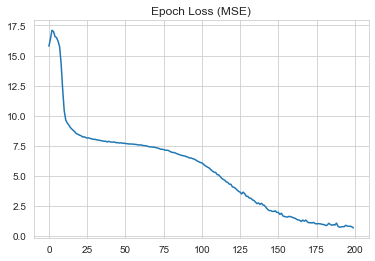

In [51]:
plt.title('Epoch Loss (MSE)')
plt.plot(epoch_losses);

In [52]:
# dataloader
    
dataset = torchData(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)

### Train Results

In [53]:
model.to(gpu)
model.eval()
train_preds = []

for i, data in enumerate(dataloader):
    inputs, target = data
    inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], 1).to(gpu)
    with torch.no_grad(): preds = model(inputs)
    train_preds.append(preds)

**Reverse transform to original temperature scale**

In [54]:
y_train = scaler.inverse_transform(np.array(y_train))
train_preds = np.array([i.to(cpu).numpy() for i in train_preds])
train_preds = scaler.inverse_transform(train_preds.reshape(train_preds.shape[0], train_preds.shape[2]))

train_error = train_preds - y_train

**Random sample of a 30-day temperature sequence predicted by the model**

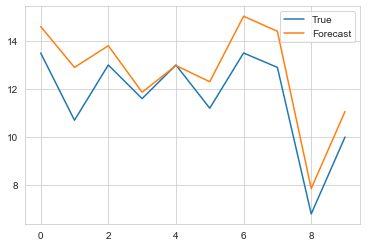

In [55]:
pred = np.random.randint(0,len(train_preds))
plt.plot(y_train[pred])
plt.plot(train_preds[pred])
plt.legend(('True','Forecast'));

**Forecast errors across entire train dataset**

                  0
count  28800.000000
mean       0.665405
std        0.966852
min       -4.797044
25%        0.094808
50%        0.719081
75%        1.276382
max        5.068245


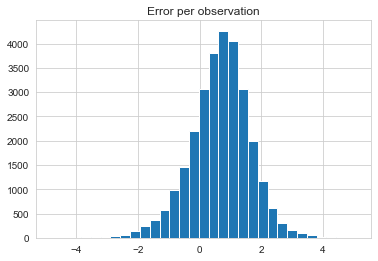

In [56]:
print(pd.DataFrame((train_preds.reshape(-1)-y_train.reshape(-1))).describe())
plt.title('Error per observation')
plt.hist(train_preds.reshape(-1)-y_train.reshape(-1), bins=31);

**RMSE - all forecasts**

In [57]:
train_RMSE = RMSE(train_preds.flatten() - y_train.flatten())
print(f'RMSE ({len(train_preds.flatten())} forecasts):\n', train_RMSE)

RMSE (28800 forecasts):
 1.173684394719585


**Distribution of RMSE per sequence**

In [58]:
train_seq_RMSE = [RMSE(i) for i in train_error]
print('Average RMSE across sequences: ',np.mean(train_seq_RMSE))

Average RMSE across sequences:  1.09781617740167


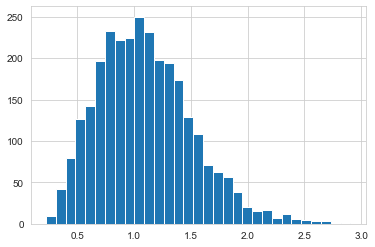

In [59]:
plt.hist(train_seq_RMSE, bins=31);

**RMSE by forecast index (day 1 to 10)**

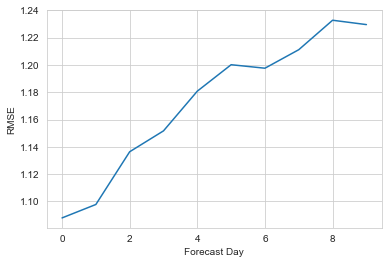

In [60]:
plt.xlabel('Forecast Day')
plt.ylabel('RMSE')
plt.plot([RMSE(train_preds.transpose()[i] - y_train.transpose()[i]) \
          for i in range(len(train_preds.transpose()))]);

### Validation Results

In [61]:
dataset_test = torchData(X_test_tensor, y_test_tensor)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=1, shuffle=False)

In [62]:
model.to(gpu)
model.eval()
test_preds = []

for i, data in enumerate(dataloader_test):
    inputs, target = data
    inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], 1).to(gpu)
    with torch.no_grad(): preds = model(inputs)
    test_preds.append(preds)

In [63]:
test_preds = (np.array([i.to(cpu).numpy() for i in test_preds]))
test_preds = scaler.inverse_transform(test_preds.reshape(test_preds.shape[0], test_preds.shape[2]))
y_test = scaler.inverse_transform(np.array(y_test))

test_error = test_preds - y_test

**Random sample of a 30-day temperature sequence predicted by the model**

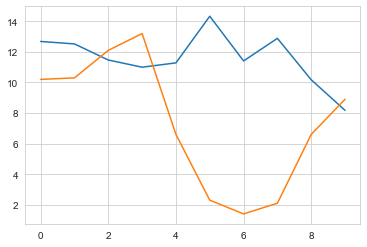

In [64]:
pred = np.random.randint(0,len(test_preds))
plt.plot(test_preds[pred])
plt.plot(y_test[pred]);

**RMSE - all observations**

In [65]:
test_error_all = (test_preds.flatten() - y_test.flatten())
print('RMSE (all observations):\n', RMSE(test_error_all))

RMSE (all observations):
 3.328703073475262


count    6900.000000
mean        0.583634
std         3.277376
min        -9.745227
25%        -1.564379
50%         0.562588
75%         2.692052
max        12.413641
dtype: float64


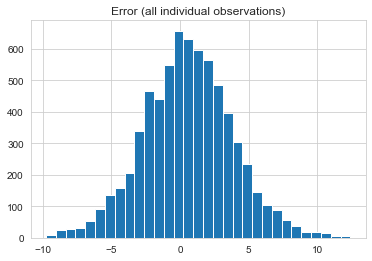

In [66]:
print(pd.Series(test_error_all).describe())
plt.title('Error (all individual observations)')
plt.hist(test_error_all, bins=31);

**Distribution of RMSE per sequence**

In [67]:
np.mean([RMSE(i) for i in test_error])

3.1865306171053946

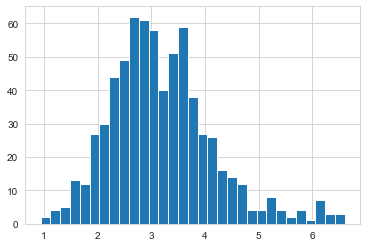

In [68]:
plt.hist([RMSE(i) for i in test_error], bins=31);

**RMSE by forecast index (day 1 to 10)**

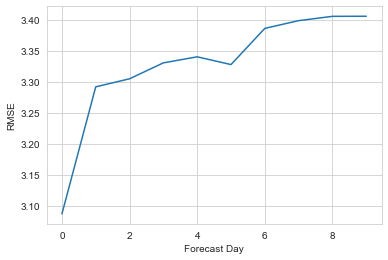

In [69]:
plt.xlabel('Forecast Day')
plt.ylabel('RMSE')
plt.plot([RMSE(test_preds.transpose()[i] - y_test.transpose()[i]) \
          for i in range(len(test_preds.transpose()))]);

# Conclusion

Both implementations were initially designed with train sequences of length 365, as there was evidently and obviously yearly seasonality in weather temperature.  As results for implementation B were less than stellar, I began altering the input sequence and forecast lengths.  The sequence length was reduced from 365 to 30 per my takeaway from implementation A, and forecast period reduced from 30 days to 10 days.  I doubled the number of epochs from 100 to 200, as all training instances exhibited increasing rate of change of loss reduction as number of epochs completed approached 100 - however the further loss reduction was probably just overfitting given the results.  

The alteration of dataset structure was motivated by general domain knowledge in response to poor results.  My initial logic was that 365 days would encapsulate yearly seasonality and stepping the training window forward one day at a time would, over enough epochs, provide enough loss reduction.  Additionally, changing the 30-day forecast in weather temperatures (an unrealistic feat in hindsight) to a 10-day forecast per current standards showed improvement across the entire forecast. Also noteworthy, in contrast to my experience thus far training the CNN model, increasing batch size seemed to have a direct deterioration in forecast quality, to the point where far too much bias was introduced.  Finally, the model seemed to be severely overfit as RMSE across multiple dimensions was markedly higher for the validation set.

Going forward, my primary objective would be to reduce the model's variance by performing a combination of increasing dropout probability, L1/L2 regularization, maintaining/increasing epochs (if warranted in response to dropout/regularization), and increasing slightly the batch size.  I have not given much consideration to the network architecture, but I would consider incrementally adjusting hyperparameters as well; my assumption is that the structure of the time-series data has a more profound impact on model performance than fine tuning network design and hence was the focus of my attention.